## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from IPython.display import clear_output
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm import tqdm
import random as rd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

## Read breastcancer file and make it useable

In [6]:
text_file = open("breastcancer_dataset.txt", "r")
lines = text_file.read().split('\n')
split_lines_list = []

for line in lines:
    split_line = line.split(',')
    split_lines_list.append(split_line)

In [7]:
df_breastcancer_dataset = pd.DataFrame(split_lines_list,columns=['ID','Outcome','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13',\
                                                'F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30'])

df_data = df_breastcancer_dataset[['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13',\
                                                'F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30']]
array_data = df_data.values
array_data.shape
for i in range(len(array_data)):
    array_data[i] = [float(j) for j in array_data[i]]
array_data

array([[17.99, 10.38, 122.8, ..., 0.2654, 0.4601, 0.1189],
       [20.57, 17.77, 132.9, ..., 0.186, 0.275, 0.08902],
       [19.69, 21.25, 130.0, ..., 0.243, 0.3613, 0.08758],
       ...,
       [16.6, 28.08, 108.3, ..., 0.1418, 0.2218, 0.0782],
       [20.6, 29.33, 140.1, ..., 0.265, 0.4087, 0.124],
       [7.76, 24.54, 47.92, ..., 0.0, 0.2871, 0.07039]], dtype=object)

In [11]:
df_breastcancer_dataset['Outcome_Binary'] = [1 if i == 'M' else 0 for i in df_breastcancer_dataset['Outcome']]

In [14]:
y_true = df_breastcancer_dataset['Outcome_Binary'].values

## Model

The kmeans library provided doesn't allow, to the best of my knowledge, to determine the number of elements assigned to a cluster. For that, I wrote a kmeans algorithm from scratch and modified it in a way that allows to set the number of elements in each cluster. Given that we only need one cluster (K=1), our case is simpler. In each iteration, we change the number of elements we need to keep in our one clusterr (p). 

1. I first set a random centroid to our model. 
2. Then I calculate the distances of all points to that centroid. 
3. I then pick the p closest points to the centroid. The rest of the points are considered outliers.
4. I calculate the position of the new centroid by ignoring the outliers. 
5. Repeat from step 2 n_iter times. 

In [15]:
accuracies = []
precisions = []
pbar = tqdm(total=569, position = 0)
for p in range(569):
    
    pbar.update(1)
    
    
    # Initialize global variables
    X = array_data  #mxn (569x30)
    m = X.shape[0] #number of training examples
    n = X.shape[1] #number of features. Here n=2
    n_iter=100 #number of iterations the kmeans will make
    K=1  # number of clusters
    Output={}  #The output of our algorithm should be a dictionary with cluster number as Keys and the data points which belong to that cluster as values.  
    Y={}
    # Initialize the centroids randomly from the data points:
    Centroids=np.array([]).reshape(n,0) 
    
    for i in range(K):
        rand=rd.randint(0,m-1)
        Centroids=np.c_[Centroids,X[rand]]
        
    #For each training example compute the euclidian distance from the centroid and assign the cluster based on the minimal distance
    for i in range(n_iter):
        EuclidianDistance=np.array([]).reshape(m,0)
        
        for k in range(K):
            tempDist=np.sum((X-Centroids[:,k])**2,axis=1)
            EuclidianDistance = np.c_[EuclidianDistance,tempDist]
            
        C=np.argmin(EuclidianDistance,axis=1)+1
        C_mine = [np.argmin(EuclidianDistance,axis=1)+1,np.min(EuclidianDistance,axis=1)]
        C_distances = C_mine[1]

        for i in range(len(C_distances)):
            C_distances[i] = [C_distances[i],int(i),1] #Create an array for each observation: [distance to centroid, original row position, 1
                                                       #signifies it won't be an outlier, we will change it later to 0 if we don't want it in the cluster.]

        C_distance_list = C_distances.tolist() # Convert to list of lists
        C_distance_list_sorted = sorted(C_distance_list, key=itemgetter(0)) # Sort it out by ascending distance to centroid, this will allow us to select the p closest points
        ids_in_cluster = [row[1] for row in C_distance_list_sorted[:p]] # Store the p first ids (row positions)
    
        # Recalculate centroid position but ignoring the outliers
        C_without_outliers = C[ids_in_cluster]
        for k in range(K):
            Y[k+1]=np.array([]).reshape(n,0)
        for i,j in zip(range(p),ids_in_cluster):
            Y[C_without_outliers[i]]=np.c_[Y[C_without_outliers[i]],X[j]]

        for k in range(K):
            Y[k+1]=Y[k+1].T

        for k in range(K):
            Centroids[:,k]=np.mean(Y[k+1],axis=0)
        Output=Y
        
    y_pred_kmeans = np.zeros(len(X))
    for i in range(len(X)):
        if i in ids_in_cluster:
            y_pred_kmeans[i] = 0 # 0 if not an outlier
        else:
            y_pred_kmeans[i] = 1 # 1 if outlier
    accuracies.append(accuracy_score(y_true, y_pred_kmeans))
    

100%|██████████| 569/569 [13:38<00:00,  3.19s/it]

In [17]:
print(max(accuracies))

0.8980667838312829


## Plot accuracy against p

Text(0.5, 1.0, 'K-means accuracy vs number of outliers allowed (p)')

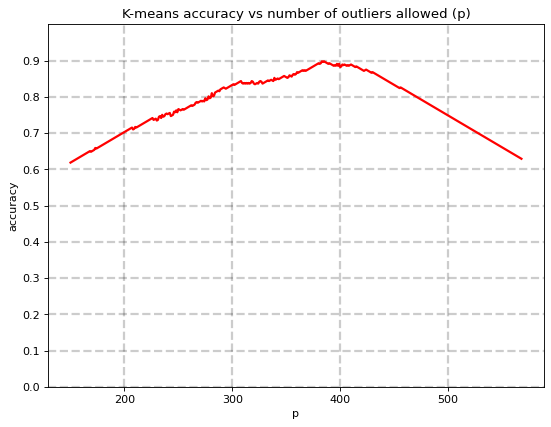

In [16]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x = list(range(569))
y = accuracies
z = precisions
plt.grid(color='black', linestyle='--', linewidth=2, alpha = 0.2)
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_facecolor('white')
plt.plot(x[150:],y[150:],color='red',linewidth = 2)
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('p')
plt.ylabel('accuracy')
plt.title('K-means accuracy vs number of outliers allowed (p)')

## ------------------Scratch----------------------

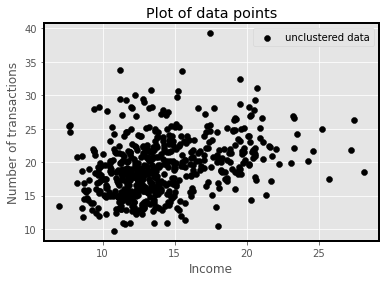

In [495]:
plt.scatter(X[:,0],X[:,1],c='black',label='unclustered data')
plt.xlabel('Income')
plt.ylabel('Number of transactions')
plt.legend()
plt.title('Plot of data points')
plt.show()

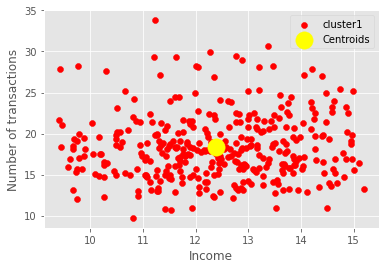

In [385]:
color=['red','blue','green','cyan','magenta']
labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
for k in range(K):
    plt.scatter(Output[k+1][:,0],Output[k+1][:,1],c=color[k],label=labels[k])
plt.scatter(Centroids[0,:],Centroids[1,:],s=300,c='yellow',label='Centroids')
plt.xlabel('Income')
plt.ylabel('Number of transactions')
plt.legend()
plt.show()

In [ ]:
df_breastcancer_dataset['Binary_Outcome'] = [1 if i == 'M' else 0 for i in df_breastcancer_dataset['Outcome']]
kmeans = KMeans(n_clusters=2)
s=kmeans.fit(array_data)
y_true = df_breastcancer_dataset['Binary_Outcome'].values
y_pred = s.labels_
accuracy_score(y_true, y_pred)

In [513]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca.fit(array_data)
G = pca.transform(array_data)